In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

In [2]:
pillbox = np.load('images/pillbox.npy')

In [3]:
def color_models_comparison(img):
    # Plot different color models
    rgb = img.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    rgb_dict = {'rgb': rgb, 'red': rgb[..., 0], 'green': rgb[..., 1], 'blue': rgb[..., 2]}
    hsv_dict = {'hsv': hsv, 'hue': hsv[..., 0], 'saturation': hsv[..., 1], 'value': hsv[..., 2]}
    hls_dict = {'hls': hls, 'hue': hls[..., 0], 'lightness': hls[..., 1], 'saturation': hls[..., 2]}
    lab_dict = {'lab': lab, 'L*': lab[..., 0], 'a*': lab[..., 1], 'b*': lab[..., 2]}
    dicts = [rgb_dict, hsv_dict, hls_dict, lab_dict]

    _, axs = plt.subplots(4, 4, figsize = (12, 10))
    for i, dct in enumerate(dicts):
        for j, (k, v) in enumerate(dct.items()):
            axs[i][j].imshow(v, cmap = 'gray')
            axs[i][j].set_title(k)
            axs[i][j].axis('off')
    plt.show()

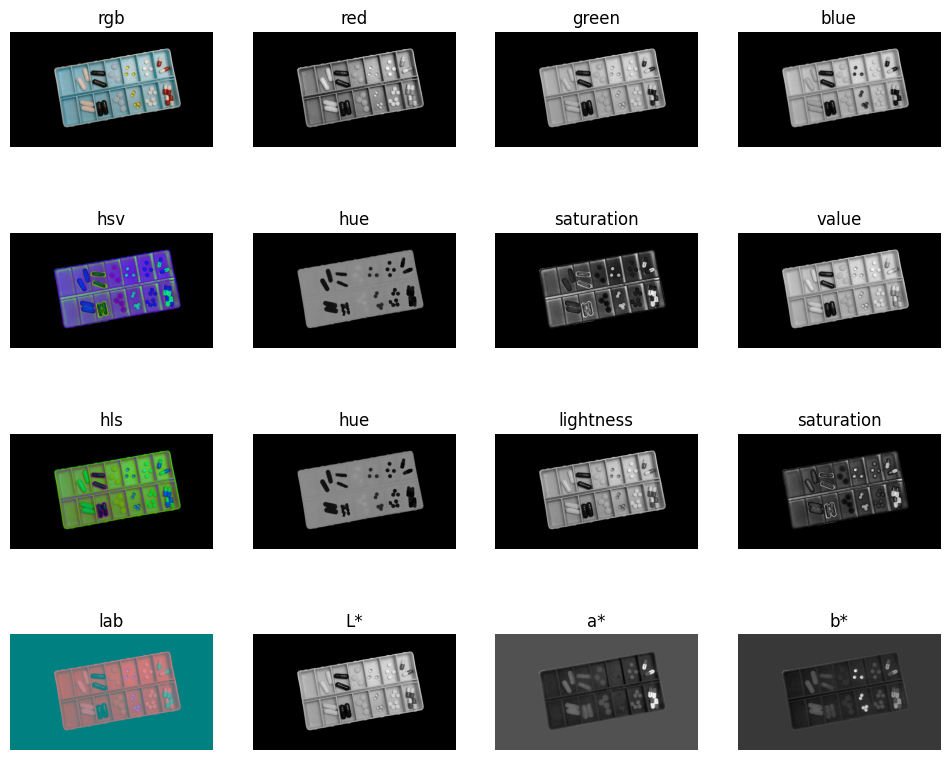

In [4]:
color_models_comparison(pillbox)

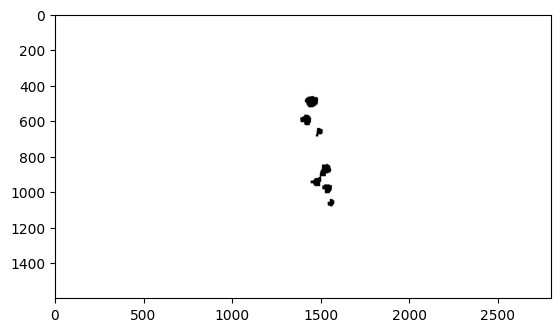

In [11]:
hue = cv2.cvtColor(pillbox, cv2.COLOR_RGB2HSV)[..., 0]
plt.imshow(hue, cmap = 'gray')
_, hue_bin = cv2.threshold(hue, 100, 180, cv2.THRESH_BINARY_INV)
hue_morph = cv2.morphologyEx(hue_bin, cv2.MORPH_CLOSE, kernel = np.ones((3, 3)), iterations = 6)
hue_morph = cv2.morphologyEx(hue_morph, cv2.MORPH_OPEN, kernel = np.ones((3, 3)), iterations = 4)
plt.imshow(hue_morph, cmap = 'gray')

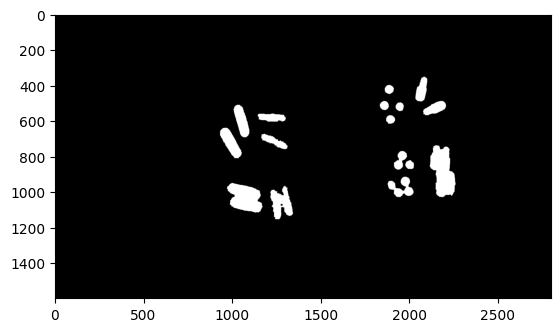

In [73]:
num_labels, labels = cv2.connectedComponents(hue_morph, connectivity = 4)
sizes = np.bincount(labels.ravel())
hue_comp = hue_morph.copy()
hue_comp[labels == np.argmax(sizes)] = 0
plt.imshow(hue_comp, cmap = 'gray')

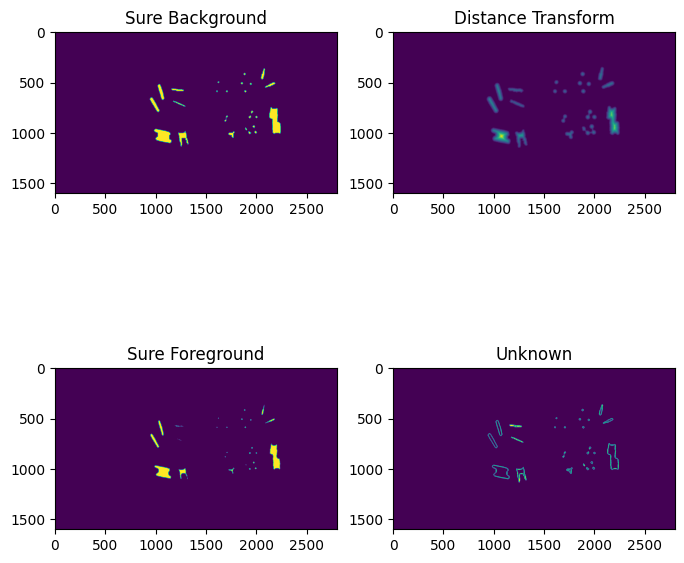

In [70]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.erode(hue_comp, kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=13)
axes[0,0].imshow(sure_bg)
axes[0, 0].set_title('Sure Background')
 
# Distance transform
dist = cv2.distanceTransform(hue_comp, cv2.DIST_L2, 5)
axes[0,1].imshow(dist)
axes[0, 1].set_title('Distance Transform')
 
#foreground area
ret, sure_fg = cv2.threshold(dist, 0.3 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
axes[1,0].imshow(sure_fg)
axes[1, 0].set_title('Sure Foreground')
 
# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
axes[1,1].imshow(unknown)
axes[1, 1].set_title('Unknown')
 
plt.show()

### PROBIO

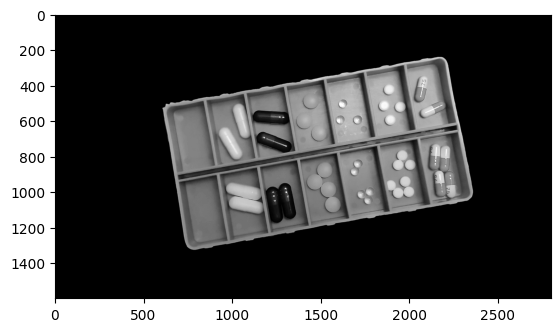

In [7]:
# test1 = cv2.cvtColor(pillbox, cv2.COLOR_RGB2LAB)[..., 1]
test1 = pillbox[..., 0]
plt.imshow(test1, cmap = 'gray')

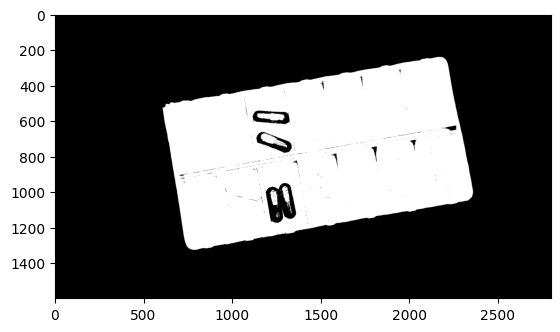

In [8]:
_, binary = cv2.threshold(test1, 25, 255, type = cv2.THRESH_BINARY)

plt.imshow(binary, cmap = 'gray')

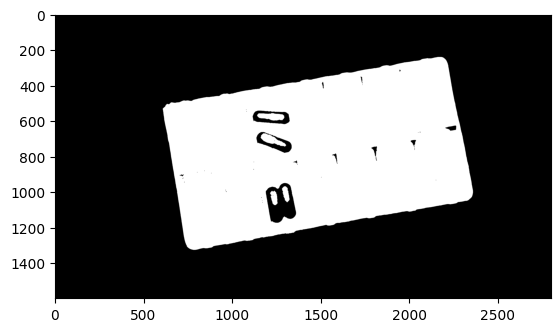

In [9]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
bin_img = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 1)
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations = 8)
plt.imshow(bin_img, cmap = 'gray')

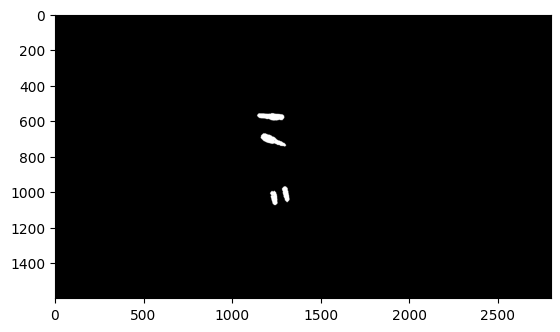

In [74]:
num_labels, labels = cv2.connectedComponents(bin_img, connectivity= 4)
sizes = np.bincount(labels.ravel())
box_idx = np.argmax(sizes[1:]) + 1
bin_img2 = bin_img.copy()

bin_img2[labels == box_idx] = 0

plt.imshow(bin_img2, cmap = 'gray')

In [13]:
# calib_hue = cv2.cvtColor(pillbox, cv2.COLOR_RGB2HSV)[..., 0]
# _, calib_hue_bin = cv2.threshold(calib_hue, 50, 180, type = cv2.THRESH_BINARY)
# plt.imshow(calib_hue_bin, cmap = 'gray')

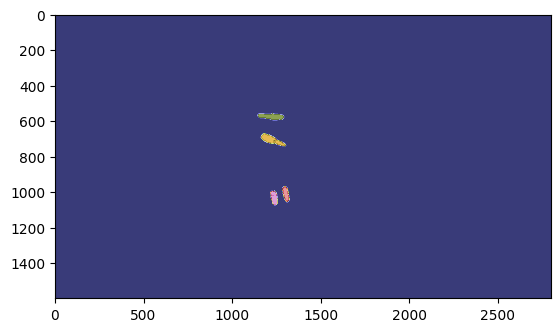

In [75]:
ret, markers = cv2.connectedComponents(bin_img2)
markers += 1

plt.imshow(markers, cmap='tab20b')

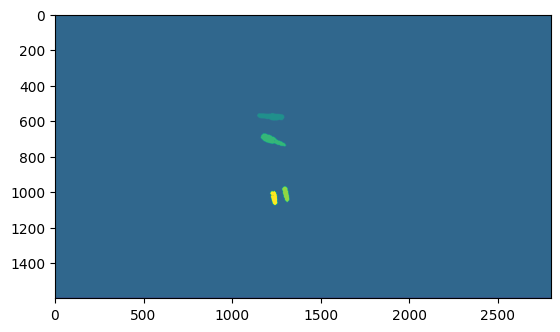

In [80]:
markers2 = cv2.watershed(pillbox, markers)
labels = np.unique(markers2)
coins = []

plt.imshow(markers2)

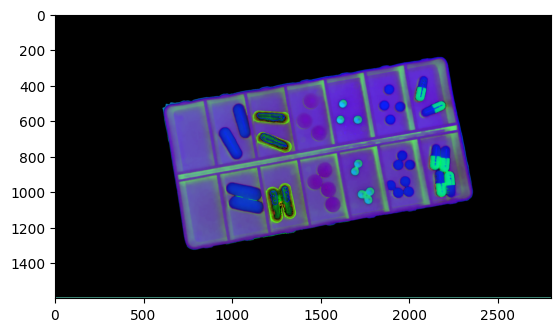

In [78]:
for label in labels[2:]:
    target = np.where(markers2 == label, 255, 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins.append(contours[0])

aa = cv2.drawContours(cv2.cvtColor(pillbox, cv2.COLOR_RGB2HSV), coins, -1, color = (0, 23, 223), thickness = 2)
plt.imshow(aa)